In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [34]:
import sys

directory_path = r'C:\Users\2MY\Documents\Uni Work\SURE\Segmentation 3\Track'

sys.path.append(directory_path) # This path must contain this current file, mask_funcs.py and utils.py

In [35]:
import torch; print(torch.version.cuda); print(torch.cuda.is_available())


None
False


In [36]:
import torch
import numpy as np
import sys
import math
import pandas as pd
import gc
import matplotlib.pyplot as plt
import subprocess
import os
from pathlib import Path
import datetime

import utils
import mask_funcs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
from skimage.measure import label, regionprops, regionprops_table

In [38]:
from re import L
class Cell:
    def __init__(self, index, directory):
        self.index = index
        self.file = directory / ("{0:04}".format(self.index) + '.csv')
        with open(self.file, 'w') as f:
            f.write('time\tarea\tspeed\tperimeter\txcentre\tycentre\teccentricity\torientation\tmajor_axis\tminor_axis')

    def write_features(self, line):
        with open(self.file, 'a') as f:
            f.write(line)

    def save_pd(self):
      pass

class CellBatch:
    def __init__(self, indices, tracked_directory,  features_directory):
        self.indices = indices
      #  print(self.indices)
        self.expanded_indices = self.indices.unsqueeze(-1).unsqueeze(-1).expand((len(indices), *IMAGE_SIZE))
      #  print(self.expanded_indices.size())
       # print(*IMAGE_SIZE)
        self.cells = [Cell(i, features_directory) for i in self.indices]
        self.centres = None
        #self.timer = 0
       # self.timer = datetime.datetime(2024, 7, 12, 0, 0, 0)
        self.timer = '00:00:00.0'
        self.timer = datetime.datetime.strptime(self.timer, '%H:%M:%S.%f')
        #print(self.timer.strftime('%H:%M:%S'))
        self.last_centres = None
        self.batch_size = len(self.indices)
        self.paths = sorted([p for p in (tracked_directory).iterdir()])
       # print(self.paths)
        self.num_frames = len(self.paths)
        self.coord_grid_x, self.coord_grid_y = torch.meshgrid(torch.arange(IMAGE_SIZE[0]).to(device),
                                                              torch.arange(IMAGE_SIZE[1]).to(device))

        self.tracked_directory = tracked_directory
        #self.epi_im_directory = epi_im_directory

    def run_feature_extraction(self):
        for i, path in enumerate(self.paths):
            sys.stdout.write(f'\rFrame {i+1} | Cells {torch.min(self.indices)}-{torch.max(self.indices)} \n')
            sys.stdout.flush()
            if i == 0:
                full_mask = torch.tensor(utils.read_tiff(path).astype(np.int16)).to(device)
                print(full_mask.max())
                self.masks = torch.where(full_mask.unsqueeze(0).expand(len(self.indices), *full_mask.shape) == self.expanded_indices, 1,0)
                print(self.masks[0].min())
                full_mask = None
            self.next_frame(path)
            self.read_features()
            #self.epi_mask = None
            self.write_features()
            torch.cuda.empty_cache()
            gc.collect()

    def next_frame(self, path):
        full_mask = torch.tensor(utils.read_tiff(path).astype(np.int16)).to(device)
        self.masks = torch.where(full_mask.unsqueeze(0).expand(len(self.indices), *full_mask.shape) == self.expanded_indices, 1, 0)
        full_mask = None
        #self.epi_mask = torch.tensor(
        #    utils.read_tiff(self.epi_im_directory / path.name).astype(np.int16)).to(device)

    def read_features(self):
        self.get_time()
        self.get_areas()
        self.get_centres()
        self.get_ecc()
        self.get_or()
        self.get_axs()
        self.get_speeds()
        self.get_perimeters()
        #self.get_eaten()
        #self.get_nearest()

    def write_features(self):
        for i, cell in enumerate(self.cells):
            new_line = (
                '\n'  + str(self.timer.strftime('%M:%S')) + '\t'
                + '\t'.join([str(a.item()) for a in (self.areas[i], self.speeds[i], self.perimeters[i], self.centres[i, 0], self.centres[i, 1])])
                + '\t' + str(self.ecc[i])
                + '\t' + str(self.ori[i])
                + '\t' + str(self.maj[i])
                + '\t' + str(self.min[i])
            )
            #self.timer += datetime.timedelta(seconds=3)
            cell.write_features(new_line)
        self.timer += datetime.timedelta(seconds=3)   
    def get_time(self):
        
        self.times = []
    def get_areas(self):
        self.areas = torch.sum(self.masks, dim=(1, 2)).float()
        self.areas[self.areas == 0] = float('nan')

    def get_centres(self):
        if self.centres is not None:
            self.last_centres = self.centres

        x_centres = torch.sum(self.masks * self.coord_grid_x, dim=(1, 2)) / self.areas
        y_centres = torch.sum(self.masks * self.coord_grid_y, dim=(1, 2)) / self.areas

        self.centres = torch.stack((x_centres, y_centres), dim=1)

    def get_ecc(self):
      self.ecc = []
      for am in self.masks:
        props = regionprops_table(
      am.cpu().numpy().astype(np.uint8),
      properties=('eccentricity',),
                                )
        if len(props['eccentricity']) == 0:
          self.ecc.append(float('nan'))
        else:
          self.ecc.append(props['eccentricity'][0])
      #print(self.ecc)

    def get_or(self):
      self.ori = []
      for am in self.masks:
        props = regionprops_table(
      am.cpu().numpy().astype(np.uint8),
      properties=('orientation',),
                                )
        if len(props['orientation']) == 0:
          self.ori.append(float('nan'))
        else:
          self.ori.append(props['orientation'][0])
      #print(self.ori)

    def get_axs(self):
      self.maj = []
      self.min = []
      for am in self.masks:
        props = regionprops_table(
      am.cpu().numpy().astype(np.uint8),
      properties=('axis_major_length','axis_minor_length',),
                                )
        if len(props['axis_major_length']) == 0:
          self.maj.append(float('nan'))
        else:
          self.maj.append(props['axis_major_length'][0])

        if len(props['axis_minor_length']) == 0:
          self.min.append(float('nan'))
        else:
          self.min.append(props['axis_minor_length'][0])

      #print(self.min)
      #print(self.maj)


    def get_speeds(self):
        if self.last_centres is None:
            self.speeds = torch.full((self.batch_size,), float('nan'))

        else:
            self.speeds = torch.sqrt((self.centres[:, 0] - self.last_centres[:, 0])**2 + (self.centres[:, 1] - self.last_centres[:, 1])**2)
        del self.last_centres

    def get_perimeters(self):
        kernel = torch.tensor([[1, 1, 1],
                               [1, 9, 1],
                               [1, 1, 1]]).to(device)

        padded_masks = torch.nn.functional.pad(self.masks, (1, 1, 1, 1), mode='constant', value=0)
        conv_result = torch.nn.functional.conv2d(padded_masks.unsqueeze(1).float(), kernel.unsqueeze(0).unsqueeze(0).float(),
                                                 padding=0).squeeze()
        self.perimeters = torch.sum((conv_result >= 10) & (conv_result <=16), dim=(1, 2)).float()
        self.perimeters[self.perimeters == 0] = float('nan')

    def get_nearest(self):
        self.masks = None # Save memory
        non_zero_pixels = torch.nonzero(self.epi_mask)
        distances = torch.sqrt(torch.sum((self.centres.unsqueeze(0) - non_zero_pixels.unsqueeze(1))**2, dim=2))
        self.dists, i = torch.min(distances, dim=0)

    def clean_up(self, threshold=50):
      # Removinf cells which are seen for < threshold number of frames
      self.tracked_masks = sorted([mask for mask in Path(phase_directory).iterdir()])
      # length_of_tracks = {index : 0 for index in range(1, self.max_index+1)}
      length_of_tracks = {}
      for i, frame_path in enumerate(self.tracked_masks):
          sys.stdout.write(
              f'\rReading frame {i + 1} / {len(self.tracked_masks)}')
          sys.stdout.flush()
          frame = torch.tensor(utils.read_tiff(frame_path).astype(np.int16)).cpu()
          for index in torch.unique(frame):
              index = index.item()
              if index != 0:
                  if index not in length_of_tracks.keys():
                      length_of_tracks[index] = 0
                  length_of_tracks[index] += 1
      tracks_to_remove = torch.tensor(
          [index for index, track_length in length_of_tracks.items() if track_length < threshold]).cpu()
      print('\n',length_of_tracks)
      print(tracks_to_remove)
      for i, frame_path in enumerate(self.tracked_masks):
          # BATCHES NEEDED TO SPEED THIS BIT UP
          sys.stdout.write(
              f'\rCleaning frame {i + 1} / {len(self.tracked_masks)}')
          sys.stdout.flush()
          frame = torch.tensor(utils.read_tiff(frame_path).astype(np.int16)).cpu()
          cleaned_frame = frame.clone()
          for track in tracks_to_remove:
              cleaned_frame[frame == track] = 0
          utils.save_tiff(cleaned_frame.to(dtype=torch.int16).cpu().numpy().astype(np.uint16), frame_path)

   # def get_eaten(self):
   #    intersection = torch.logical_and(self.masks, self.epi_mask.unsqueeze(0))
    #   self.eaten = intersection.sum(dim=(1, 2)).int()

## Feature Extraction
For each detected cell, saves .txt file with value for each feature at each frame

In [39]:

# inputs
tracked_directory = r'C:\Users\2MY\Documents\Uni Work\SURE\Segmentation 3\Track\Tracks'
#epi_directory = '/content/drive/Shareddrives/Tracking_and_features/Tracking_and_feature_extraction/Thresholded_Epi' # path to THRESHOLDED epi images (binary)
# output
features_directory = r'C:\Users\2MY\Documents\Uni Work\SURE\Segmentation 3\Track\Features'

phase_directory = r'C:\Users\2MY\Documents\Uni Work\SURE\Segmentation 3\Phase_masks\amoeba'

utils.remake_dir(Path(features_directory))

IMAGE_SIZE = utils.read_tiff([i for i in (Path(tracked_directory).iterdir())][0]).shape

with torch.no_grad():
    cell_batch = CellBatch(torch.tensor(np.arange(1, 101)).to(device), Path(tracked_directory),  Path(features_directory))
    cell_batch.run_feature_extraction()

Frame 1 | Cells 1-100 
tensor(36, dtype=torch.int16)
tensor(0)
Frame 2 | Cells 1-100 
Frame 3 | Cells 1-100 
Frame 4 | Cells 1-100 
Frame 5 | Cells 1-100 
Frame 6 | Cells 1-100 
Frame 7 | Cells 1-100 
Frame 8 | Cells 1-100 
Frame 9 | Cells 1-100 
Frame 10 | Cells 1-100 


In [40]:
cell_batch.clean_up()

Reading frame 10 / 10
 {}
tensor([])
Cleaning frame 10 / 10

In [41]:
def clean_directory(features_directory,out_dir):
    utils.remake_dir(Path(out_dir))

    for i,cell in enumerate((Path(features_directory)).iterdir()):
      df = pd.read_csv(cell, sep='\t')
    
      if np.isnan(df['area'][0]) == True:
        continue
      else:
          filepath = os.path.join(out_dir,f'cell_{i+1}')
          df.to_csv(f'{filepath}.csv', index=False)

viable_cell_dir = r'C:\Users\2MY\Documents\Uni Work\SURE\Segmentation 3\Track\final_cells'
clean_directory(features_directory, viable_cell_dir)

In [15]:
viable_cell_dir = Path(r'C:\Users\2MY\Documents\Uni Work\SURE\Segmentation 3\Track\final_cells')

utils.remake_dir(viable_cell_dir)

for i, cell in enumerate(viable_cells.values()):
    filepath = os.path.join(viable_cell_dir,f'cell{i+1}.csv')
    cell.to_csv(filepath, index=False,)


## Plot features
Plot graphs showing each feature over time for each cell

In [30]:
import utils


---------------
Plotting Features
---------------



IndexError: single positional indexer is out-of-bounds

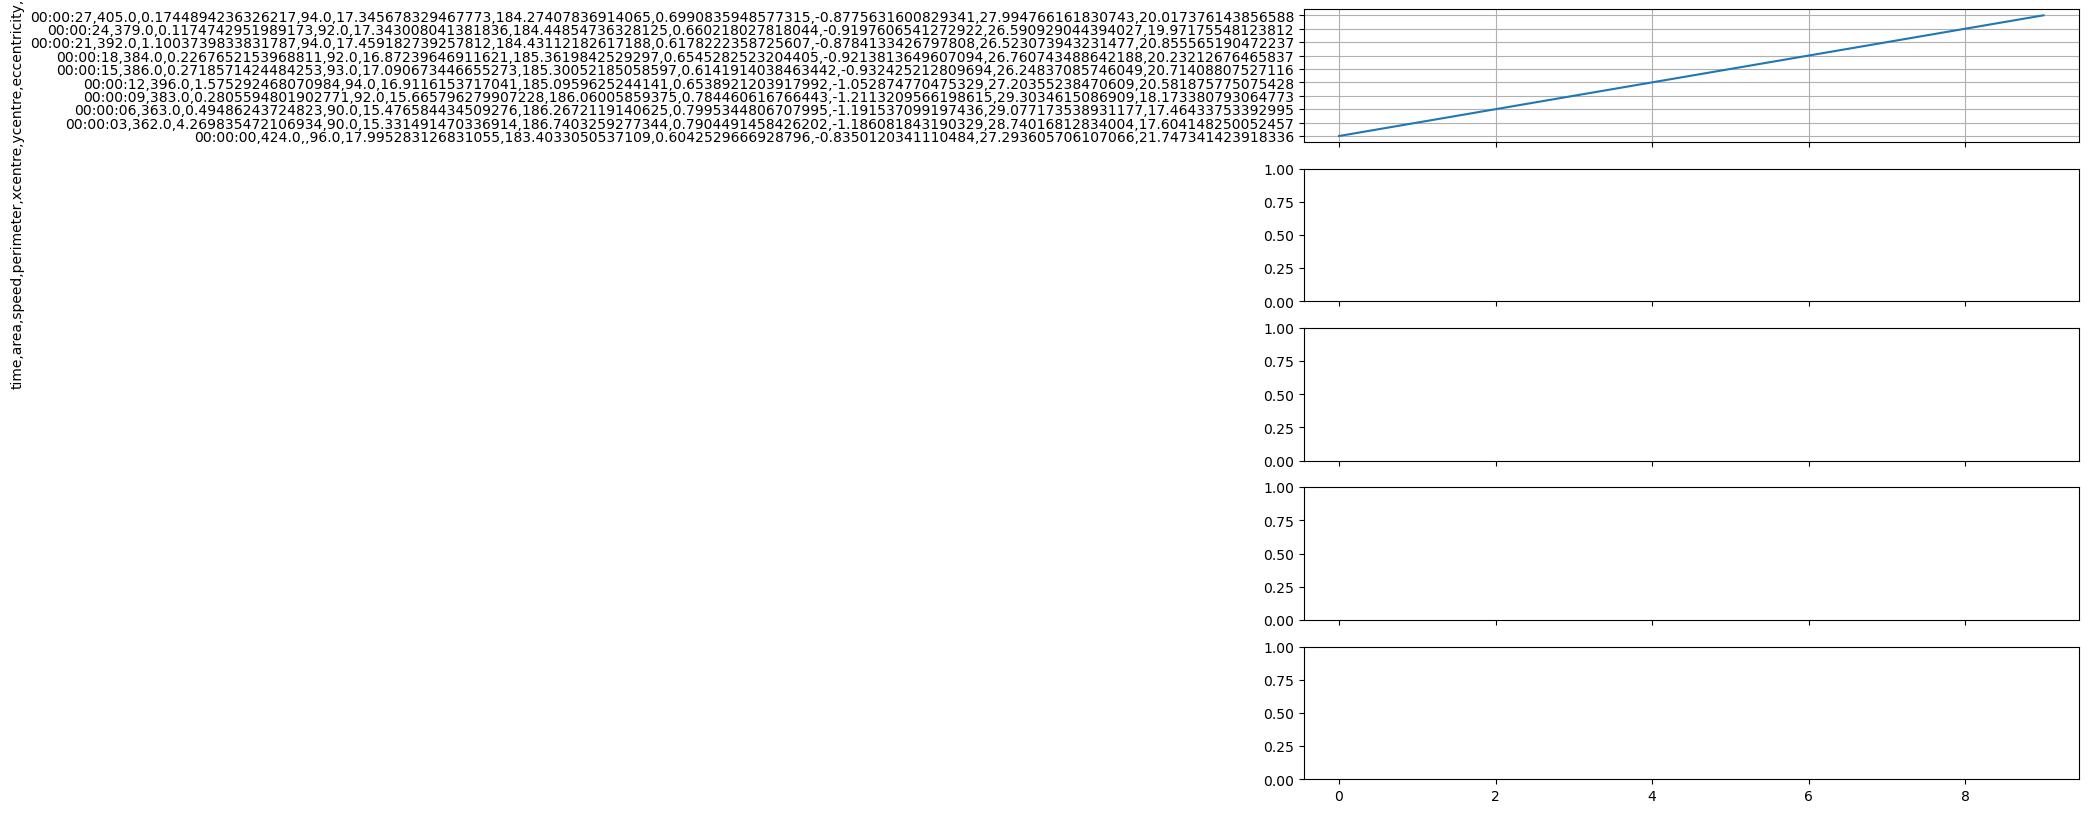

In [33]:
# output
feature_plots_dir = r'feature_plots'

utils.remake_dir(Path(feature_plots_dir))

def plot_features():
    print('\n---------------\nPlotting Features\n---------------\n')
    for features_path in (Path(viable_cell_dir)).iterdir():
        data = pd.read_csv(features_path, sep='\t')
        fig, axs = plt.subplots(5, sharex=True, figsize=(10, 10))
        for i in range(5):
            axs[i].plot(data.iloc[:, i])
            axs[i].set(ylabel=data.columns.values.tolist()[i])
            axs[i].grid()

        fig.suptitle('Amoeba '+ features_path.stem)
        axs[-1].set(xlabel='frames')
        plt.savefig(Path(feature_plots_dir) / str(features_path.stem+'.png'))
        plt.close()

plot_features()

## Plot Tracks
Saves a single .png with lines showing movement of the centre of each cell

In [ ]:
# output
save_track_plot_as = '/content/drive/Shareddrives/Tracking_and_features/Tracking_and_feature_extraction/tracked_plot.png'

def plot_tracks(features_directory, save_plot_as):
    tracks_plot = torch.zeros(*IMAGE_SIZE, 3).to(device).to(float)
    print('\n---------------\nPlotting Tracks\n---------------\n')
    for features in (Path(features_directory)).iterdir():
        data = pd.read_csv(features, sep='\t')
        colour = torch.tensor(np.random.uniform(0, 2**(8)-1, size=3)).to(device)
        centres = torch.tensor(data.loc[:, 'xcentre':'ycentre'].values).to(device)
        for i in range(len(centres) - 1):
            if not torch.any(centres[i:i+2].isnan()):
                tracks_plot = utils.draw_line(tracks_plot, centres[i, 0], centres[i+1, 0], centres[i, 1], centres[i+1, 1], colour)
    utils.save_tiff(tracks_plot.cpu().numpy().astype(np.uint8), Path(save_plot_as))

plot_tracks(features_directory, save_track_plot_as)

## Show eating
Detects when phagocytsis is happening (currently just finds when epifluorescenct yeast is detected within amoeba border, needs improving), and saves .jpg for each frame with amoeba outlined.

In [ ]:
# input
phase_images = '/content/drive/Shareddrives/Tracking_and_features/Tracking_and_feature_extraction/INPUTS/phase'


# output
show_eating_dir = '/content/drive/Shareddrives/Tracking_and_features/Tracking_and_feature_extraction/Show_Eating'

utils.remake_dir(Path(show_eating_dir))

def show_eating(phase_images, epi_images, phase_tracks, features, show_eating_dir):
    for features in (Path(features)).iterdir():
        data = pd.read_csv(features, delimiter='\t')
        eaten_frames = data.index[data['eaten']>=1].tolist()
        if len(eaten_frames) > 0:
            (Path(show_eating_dir) / features.stem).mkdir(exist_ok=True)
            for eaten_frame in eaten_frames:
                image = torch.tensor(utils.read_tiff(Path(phase_images) / ('t' + "{0:04}".format(eaten_frame) + '.jpg'))).to(device)
                epi_image = torch.tensor(utils.read_tiff(Path(epi_images) / ("{0:04}".format(eaten_frame) + '.tif')).astype(np.float32)).to(device)
                mask = torch.tensor(utils.read_tiff(Path(phase_tracks) / ("{0:04}".format(eaten_frame)+'.tif')).astype(np.int16)).to(device)
                outline = mask_funcs.mask_outline(torch.where(mask==int(features.stem), 1, 0), thickness=3)
                epi_image_normalised = (epi_image - epi_image.min()) / (epi_image.max() - epi_image.min()) * 255
                im_rgb = torch.stack((image, image, image), axis=0)

                im_rgb[0] = torch.where(outline, 0, im_rgb[0])
                im_rgb[1] = torch.where(outline, 0, im_rgb[1])
                im_rgb[2] = torch.where(outline, 255, im_rgb[2])

                im_rgb[0] = torch.where(epi_image > 0, epi_image_normalised, im_rgb[0])
                im_rgb[1] = torch.where(epi_image > 0, 0, im_rgb[1])
                im_rgb[2] = torch.where(epi_image > 0, 0, im_rgb[2])


                im_rgb = im_rgb.permute(1, 2, 0)

                utils.save_tiff((im_rgb).cpu().numpy().astype(np.uint8), Path(show_eating_dir) / features.stem /("{0:04}".format(eaten_frame) + '.jpg'))

show_eating(phase_images, epi_directory, tracked_directory, features_directory, show_eating_dir)